In [1]:
from astrometry.util.fits import *
import pylab as plt
from collections import Counter
from astropy.table import Table
from astrometry.util.starutil_numpy import *
from scipy.optimize import brentq
from astrometry.util.util import radecdegtohealpix
from astrometry.util.util import *
from astrometry.util.miscutils import point_in_poly
import os

In [2]:
import matplotlib
# LaTeX for plots
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='serif')

In [3]:
# Read Anand's healpixed footprint table
fn = 'surveys-footprints-nside128.fits'
if not os.path.exists(fn):
    fn = '/global/cfs/cdirs/desi/users/raichoor/footprints/surveys-footprints-nside128.fits'
T = fits_table(fn)

In [4]:
T.about()

tabledata object with 196608 rows and 55 columns:
   act_dr5 (<class 'numpy.ndarray'>) shape (196608,) dtype bool
   act_dr5_patchid (<class 'numpy.ndarray'>) shape (196608,) dtype >i8
   cfis_r (<class 'numpy.ndarray'>) shape (196608,) dtype bool
   cfis_r_patchid (<class 'numpy.ndarray'>) shape (196608,) dtype >i8
   cfis_u (<class 'numpy.ndarray'>) shape (196608,) dtype bool
   cfis_u_patchid (<class 'numpy.ndarray'>) shape (196608,) dtype >i8
   ctio_airmass (<class 'numpy.ndarray'>) shape (196608,) dtype >f8
   dec (<class 'numpy.ndarray'>) shape (196608,) dtype >f8
   des (<class 'numpy.ndarray'>) shape (196608,) dtype bool
   des_patchid (<class 'numpy.ndarray'>) shape (196608,) dtype >i8
   desi1b_bright (<class 'numpy.ndarray'>) shape (196608,) dtype bool
   desi1b_bright_patchid (<class 'numpy.ndarray'>) shape (196608,) dtype >i8
   desi1b_dark (<class 'numpy.ndarray'>) shape (196608,) dtype bool
   desi1b_dark_patchid (<class 'numpy.ndarray'>) shape (196608,) dtype >i8
   de

In [5]:
Counter(T.ibis_wide_patchid)

Counter({np.int64(-1): 171268, np.int64(1): 13757, np.int64(2): 11583})

In [40]:
# Choose how to wrap RA

ralo = -84.
rahi = 276.
declo = -20.
dechi = +20.

def ra_display(ra):
    return ra + -360 * (ra > rahi)

In [7]:
T.ra_display = ra_display(T.ra)

In [8]:
# Compute the IBIS footprint

# SGC (b < 0):
# -15 < dec < 6 AND ((b < -27 AND ra > 270) OR (b < -47 AND ra < 90))
# ---> later, we shifted this down by 3 degrees to be within the Rubin/LSST footprint
sgc_dec_min = -18
sgc_dec_max =  +3
# "Left" and "Right" here were when I was looking at a plot with RA not flipped!!
sgc_left_b = -27
sgc_right_b = -47

# "left" (high-RA) edge of SGC
# Find L range corresponding to B=-27, Dec=-18 and +3
l_min = brentq(lambda ell: galactictoradec(ell, sgc_left_b)[1] - sgc_dec_min, 0., 90.)
l_max = brentq(lambda ell: galactictoradec(ell, sgc_left_b)[1] - sgc_dec_max, 0., 90.)
ll = np.linspace(l_min, l_max, 50)
bb = np.zeros_like(ll) + sgc_left_b
r1,d1 = galactictoradec(ll, bb)
print('IBIS SGC: L [%7.3f to %7.3f], B=%+.3f; RA [%7.3f to %7.3f], Dec [%+8.3f to %+8.3f]' %
      (l_min, l_max, sgc_left_b, min(r1), max(r1), min(d1), max(d1)))

# Right edge of SGC
l_min = brentq(lambda ell: galactictoradec(ell, sgc_right_b)[1] - sgc_dec_min, 150., 250.)
l_max = brentq(lambda ell: galactictoradec(ell, sgc_right_b)[1] - sgc_dec_max, 150., 250.)
ll = np.linspace(l_min, l_max, 50)
bb = np.zeros_like(ll) + sgc_right_b
r2,d2 = galactictoradec(ll, bb)
print('IBIS SGC: L [%7.3f to %7.3f], B=%+.3f; RA [%7.3f to %7.3f], Dec [%+8.3f to %+8.3f]' %
      (l_min, l_max, sgc_right_b, min(r2), max(r2), min(d2), max(d2)))

# polygon
ibis_sgc = [
    (r1,d1),
    # bottom
    (np.array([max(r1), min(r2)]), np.array([sgc_dec_max]*2)),
    (r2[::-1],d2[::-1]),
    # top
    (np.array([max(r2), min(r1)]), np.array([sgc_dec_min]*2)),
]

# NGC (b > 0):
# -7 < dec < 15 AND ((b > 22 AND ra <= 180) OR (b > 30 AND ra >= 180 AND dec > 1) OR (b > 46 AND ra >= 180 AND dec > -10))
ngc_left_b = +22
ngc_left_dec_min = -7
ngc_left_dec_max = 15

ngc_right1_b = +30
ngc_right1_dec_min = 1
ngc_right1_dec_max = 15

ngc_right2_b = +46
ngc_right2_dec_max = 1
ngc_right2_dec_min = -7

# Left edge of NGC
l_min = brentq(lambda ell: galactictoradec(ell, ngc_left_b)[1] - ngc_left_dec_min, 180., 270.)
l_max = brentq(lambda ell: galactictoradec(ell, ngc_left_b)[1] - ngc_left_dec_max, 180., 270.)
ll = np.linspace(l_min, l_max, 50)
bb = np.zeros_like(ll) + ngc_left_b
r3,d3 = galactictoradec(ll, bb)
print('IBIS NGC: L [%7.3f to %7.3f], B=%+.3f; RA [%7.3f to %7.3f], Dec [%+8.3f to %+8.3f]' %
      (l_min, l_max, ngc_left_b, min(r3), max(r3), min(d3), max(d3)))

# Far right edge of NGC
l_min = brentq(lambda ell: galactictoradec(ell, ngc_right1_b)[1] - ngc_right1_dec_min, 0., 90.)
l_max = brentq(lambda ell: galactictoradec(ell, ngc_right1_b)[1] - ngc_right1_dec_max, 0., 90.)
ll = np.linspace(l_min, l_max, 50)
bb = np.zeros_like(ll) + ngc_right1_b
r4,d4 = galactictoradec(ll, bb)
print('IBIS NGC: L [%7.3f to %7.3f], B=%+.3f; RA [%7.3f to %7.3f], Dec [%+8.3f to %+8.3f]' %
      (l_min, l_max, ngc_right1_b, min(r4), max(r4), min(d4), max(d4)))

# Near right edge of NGC
l_min = brentq(lambda ell: galactictoradec(ell, ngc_right2_b)[1] - ngc_right2_dec_min, 300., 380.)
l_max = brentq(lambda ell: galactictoradec(ell, ngc_right2_b)[1] - ngc_right2_dec_max, 300., 380.)
ll = np.linspace(l_min, l_max, 50)
bb = np.zeros_like(ll) + ngc_right2_b
r5,d5 = galactictoradec(ll, bb)
print('IBIS NGC: L [%7.3f to %7.3f], B=%+.3f; RA [%7.3f to %7.3f], Dec [%+8.3f to %+8.3f]' %
      (l_min, l_max, ngc_right2_b, min(r5), max(r5), min(d5), max(d5)))
#ibis_rd = [(r1,d1),(r2,d2),(r3,d3),(r4,d4),(r5,d5)]

# polygon
ibis_ngc = [
    (r3, d3),
    # top of NGC
    (np.array([min(r3), max(r4)]), np.array([ngc_left_dec_max]*2)),
    (r4[::-1],d4[::-1]),
    (np.array([min(r4), max(r5)]), np.array([ngc_right1_dec_min]*2)),
    (r5[::-1],d5[::-1]),
    (np.array([min(r5), max(r3)]), np.array([ngc_left_dec_min]*2)),
]

IBIS SGC: L [ 25.541 to  52.022], B=-27.000; RA [304.568 to 315.384], Dec [ -18.000 to   +3.000]
IBIS SGC: L [210.622 to 173.464], B=-47.000; RA [ 44.677 to  58.627], Dec [ -18.000 to   +3.000]
IBIS NGC: L [233.706 to 206.810], B=+22.000; RA [120.226 to 132.002], Dec [  -7.000 to  +15.000]
IBIS NGC: L [ 17.080 to  35.224], B=+30.000; RA [249.290 to 256.478], Dec [  +1.000 to  +15.000]
IBIS NGC: L [346.240 to 362.778], B=+46.000; RA [221.549 to 229.783], Dec [  -7.000 to   +1.000]


In [9]:
# The HSC-Niji bounds were just eyeballed from the proposal!  The values here over-estimate the area,
# certainly the area that will have full-depth coverage.

# HSC-Niji - WIDE field 1
r1,r2,r3 = 40, 28, 23
d1,d2,d3 = -7, -1.5, +5
rr1 = np.array([r1, r3, r3, r2, r2, r1, r1])
dd1 = np.array([d3, d3, d2, d2, d1, d1, d3])
# area:
area1 = np.abs((r2-r1)*(np.rad2deg(np.sin(np.deg2rad(d3))-np.sin(np.deg2rad(d1)))) +
               (r3-r2)*(np.rad2deg(np.sin(np.deg2rad(d3))-np.sin(np.deg2rad(d2)))))

# HSC-Niji - WIDE field 2
r1,r2,r3 = -9, -19, -30
d1,d2,d3 = -1.5, 6, 7.5
rr2 = np.array([r1, r2, r2, r3, r3, r1, r1])
dd2 = np.array([d2, d2, d3, d3, d1, d1, d2])
# area:
area2 = np.abs((r2-r1)*(np.rad2deg(np.sin(np.deg2rad(d2))-np.sin(np.deg2rad(d1)))) +
               (r3-r2)*(np.rad2deg(np.sin(np.deg2rad(d3))-np.sin(np.deg2rad(d1)))))

# HSC-Niji - WIDE field 3
r1,r2 = 226, 204
d1,d2 = -2.5, +5
rr3 = np.array([r1, r2, r2, r1, r1])
dd3 = np.array([d2, d2, d1, d1, d2])
# area:
area3 = np.abs((r1-r2)*(np.rad2deg(np.sin(np.deg2rad(d2))-np.sin(np.deg2rad(d1)))))

# HSC-Niji - WIDE field 4
r1,r2 = 152,130
d1,d2 = -2.5, +5
rr4 = np.array([r1, r2, r2, r1, r1])
dd4 = np.array([d2, d2, d1, d1, d2])
# area:
area4 = np.abs((r1-r2)*(np.rad2deg(np.sin(np.deg2rad(d2))-np.sin(np.deg2rad(d1)))))

niji_polys = [(rr1,dd1), (rr2,dd2), (rr3,dd3), (rr4,dd4)]
print('HSC/Niji areas: %.1f, %.1f, %.1f, %.1f sq deg, total %.1f sq deg' % (area1, area2, area3, area4, (area1+area2+area3+area4)))

HSC/Niji areas: 176.2, 173.7, 164.8, 164.8 sq deg, total 679.5 sq deg


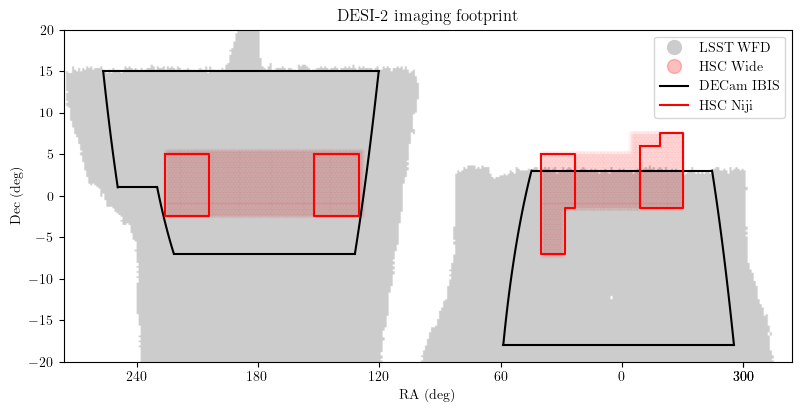

In [10]:
plt.figure(figsize=(8,4))
plt.subplots_adjust(left=0.08, right=0.99, top=0.94, bottom=0.11)

# Make an RA,Dec-space image of the Rubin/LSST WFD footprint
rr,dd = np.meshgrid(np.linspace(ralo, rahi, 361), np.linspace(declo, dechi, 201))
nside = 128
hp = np.array([healpix_xy_to_nested(radecdegtohealpix(r, d, nside), nside) for r,d in zip(rr.ravel(), dd.ravel())]).reshape(rr.shape)
I = np.flatnonzero(T.rubin_wfd)
hp_in_rubin = set(T.hpxpixel[I])
inrubin = np.array([h in hp_in_rubin for h in hp.ravel()]).reshape(hp.shape)
# Set the vmin/vmax range to make True -> light gray, False -> white
plt.imshow(1 - inrubin, extent=[ralo,rahi,declo,dechi], origin='lower', cmap='gray', vmin=-4, vmax=1, aspect='auto')
#plt.plot(T.ra_display[I], T.dec[I], '.', color='0.5', alpha=0.02, label='LSST WFD')

#I = np.flatnonzero(T.ibis_wide)
#plt.plot(T.ra_display[I], T.dec[I], '.', color='b', alpha=0.02, label='IBIS Wide')

# Show the HSC-SSP wide footprint in light red
I = np.flatnonzero(T.hsc_wide)
plt.plot(T.ra_display[I], T.dec[I], '.', color='r', alpha=0.02)

# Plot fake points just for the legend
p_lsst = plt.plot(-100, 0, '.', color='0.8', ms=20, label='LSST WFD')
p_hsc = plt.plot(-100, 0, '.', color='r', alpha=0.25, ms=20, label='HSC Wide')

for i,(r,d) in enumerate(ibis_sgc + ibis_ngc):
    kw = {}
    if i == 0:
        kw.update(label='DECam IBIS')
    plt.plot(ra_display(r), d, 'k-', **kw)

for i,(r,d) in enumerate(niji_polys):
    kw = {}
    if i == 0:
        kw.update(label='HSC Niji')
    plt.plot(ra_display(r), d, 'r-', **kw)

plt.legend()

xt = [300, 0, 60, 120, 180, 240, 300]
plt.xticks(ra_display(np.array(xt)), xt)
plt.ylim(declo, dechi)
plt.xlim(rahi, ralo);
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)');
plt.title('DESI-2 imaging footprint')
plt.savefig('footprint.pdf')
plt.savefig('footprint.png')

In [11]:
poly_ibis_ngc = np.vstack((ra_display(np.hstack([r for r,d in ibis_ngc])), np.hstack([d for r,d in ibis_ngc])))
poly_ibis_sgc = np.vstack((ra_display(np.hstack([r for r,d in ibis_sgc])), np.hstack([d for r,d in ibis_sgc])))

In [12]:
T.ibis_wide_bounds = np.zeros(len(T), bool)
for poly in [poly_ibis_ngc, poly_ibis_sgc]:
    T.ibis_wide_bounds |= point_in_poly(T.ra_display, T.dec, poly.T)

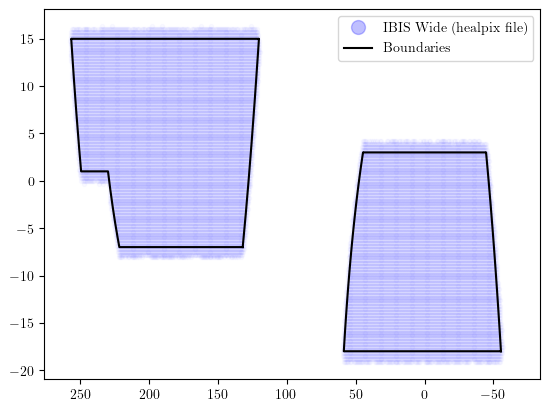

In [13]:
I = np.flatnonzero(T.ibis_wide)
n3 = len(I)
in_ngc = point_in_poly(T.ra_display[I], T.dec[I], poly_ibis_ngc.T)
in_sgc = point_in_poly(T.ra_display[I], T.dec[I], poly_ibis_sgc.T)
plt.plot(T.ra_display[I], T.dec[I], '.', color='b', alpha=0.02)
# just for the legend
plt.plot(-100, 0, '.', color='b', alpha=0.25, ms=20, label='IBIS Wide (healpix file)')
plt.plot(poly_ibis_ngc[0,:], poly_ibis_ngc[1,:], 'k-')
plt.plot(poly_ibis_sgc[0,:], poly_ibis_sgc[1,:], 'k-', label='Boundaries');
plt.legend()
plt.xlim(rahi, ralo)
plt.savefig('ibis-bounds.png')

In [14]:
# blue area
I = np.flatnonzero(T.ibis_wide_bounds)
n5 = len(I)
a5 = (n5) / (12*nside**2) * 4 * np.pi * np.rad2deg(1.)**2
a5

np.float64(4705.7096452877095)

In [15]:
# black bounds
(n3) / (12*nside**2) * 4 * np.pi * np.rad2deg(1.)**2

np.float64(5316.925242412742)

In [16]:
T.hsc_niji = np.zeros(len(T), bool)
for r,d in niji_polys:
    poly = np.vstack((r,d)).T
    in_poly = point_in_poly(T.ra_display, T.dec, poly)
    T.hsc_niji |= in_poly
I = np.flatnonzero(T.hsc_niji)
n4 = len(I);

In [17]:
# Niji areas
(n4) / (12*nside**2) * 4 * np.pi * np.rad2deg(1.)**2

np.float64(682.5555569679814)

In [18]:
# In IBIS, not in HSC/Niji
I = np.flatnonzero(T.ibis_wide_bounds * ~T.hsc_niji)
n6 = len(I)
a6 = (n6) / (12*nside**2) * 4 * np.pi * np.rad2deg(1.)**2
a6

np.float64(4132.472085608482)

In [19]:
Counter(T.ibis_wide_bounds)

Counter({np.False_: 174181, np.True_: 22427})

In [20]:
Counter(T.hsc_niji)

Counter({np.False_: 193355, np.True_: 3253})

In [22]:
# LaTeX for plots
matplotlib.rc('text', usetex=False)
matplotlib.rc('font', family='sans')

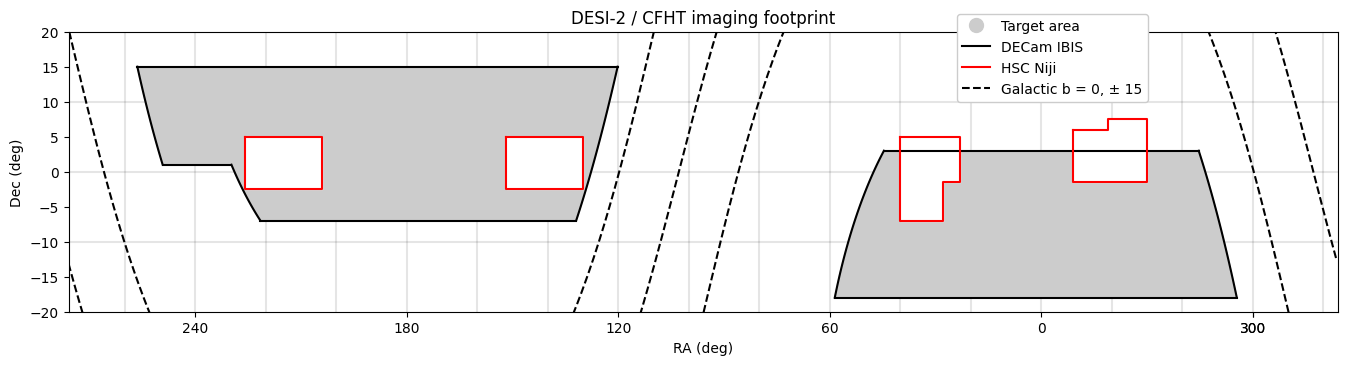

In [101]:
# CFHT footprint

#plt.figure(figsize=(18,4))
#plt.figure(figsize=(9,2))
plt.figure(figsize=(13.5,3.5))
#plt.subplots_adjust(left=0.08, right=0.99, top=0.94, bottom=0.11)
plt.subplots_adjust(left=0.05, right=0.99, top=0.93, bottom=0.13)

if False:
    # Build an RA,Dec grid to shade the target area
    rr,dd = np.meshgrid(np.linspace(ralo, rahi, 361), np.linspace(declo, dechi, 201))
    nside = 128
    I = np.flatnonzero(T.ibis_wide_bounds * ~T.hsc_niji)
    hp_in = set(T.hpxpixel[I])
    inhp = np.array([h in hp_in for h in hp.ravel()]).reshape(hp.shape)
    # Set the vmin/vmax range to make True -> light gray, False -> white
    plt.imshow(1 - inhp, extent=[ralo,rahi,declo,dechi], origin='lower', cmap='gray', vmin=-4, vmax=1, aspect='auto')

rr = np.hstack([r for r,d in ibis_sgc])
dd = np.hstack([d for r,d in ibis_sgc])
plt.fill(ra_display(rr), dd, color='0.8')
rr = np.hstack([r for r,d in ibis_ngc])
dd = np.hstack([d for r,d in ibis_ngc])
plt.fill(ra_display(rr), dd, color='0.8')#, zorder=-14)
for i,(r,d) in enumerate(niji_polys):
    plt.fill(ra_display(r), d, color='1')#, zorder=-12)

# Plot fake points just for the legend
p_area = plt.plot(-100, 0, '.', color='0.8', ms=20, label='Target area')

for i,(r,d) in enumerate(ibis_sgc + ibis_ngc):
    kw = {}
    if i == 0:
        kw.update(label='DECam IBIS')
    plt.plot(ra_display(r), d, 'k-', **kw)

for i,(r,d) in enumerate(niji_polys):
    kw = {}
    if i == 0:
        kw.update(label='HSC Niji')
    plt.plot(ra_display(r), d, 'r-', **kw)

ll = np.linspace(0, 360, 360)
zz = np.zeros_like(ll)
for ib,bb in enumerate([zz, zz+15, zz-15]):
    rr,dd = galactictoradec(ll, bb)
    kw = {}
    if ib == 0:
        kw.update(label='Galactic b = 0, ± 15')
    I = np.flatnonzero((rr > rahi) * (ll < 180))
    plt.plot(ra_display(rr[I]), dd[I], 'k--', **kw)
    I = np.flatnonzero((rr > 0) * (rr < 180))
    plt.plot(ra_display(rr[I]), dd[I], 'k--')
    I = np.flatnonzero((rr > 180) * (rr < rahi) * (ll < 180))
    plt.plot(ra_display(rr[I]), dd[I], 'k--')
    I = np.flatnonzero((rr > 180) * (rr < rahi) * (ll > 180))
    plt.plot(ra_display(rr[I]), dd[I], 'k--')

plt.legend(loc=(0.7,0.75), framealpha=1.)

for d in [0, -10, +10]:
    plt.axhline(d, zorder=-10, color='k', alpha=0.1)

xt = [300, 0, 60, 120, 180, 240, 300]

for r in np.arange(0, 360, 20):
    plt.axvline(ra_display(r), zorder=-10, color='k', alpha=0.1)

plt.xticks(ra_display(np.array(xt)), xt)
plt.ylim(declo, dechi)
plt.xlim(rahi, ralo);
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)');
plt.title('DESI-2 / CFHT imaging footprint')
plt.savefig('footprint2.pdf')
plt.savefig('footprint2.png')
